# <div align="center" style="font-size: 50px;">Machine Intelligence Exam</div>

### **Instructions**:

- Students are allowed to use any notes and material they want (physical or electronic).
- Students are allowed to use web search to find information
- Students are not allowed to use any generative AI tool or any automatic code generation.  
- Students are allowed to use any IDE they want (e.g., Visual Code, PyCharm) and Google Colab.
- The IDE or Google Colab must not have any generative AI tool activated for code generation.  

### **Submission**:

- The submission must be a single Python notebook.
- The notebook must be named *MI_Exam.ipynb*.
- **The notebook must be submitted in Digital Exam before the end of the exam**


NICKLAS VISTOFT KLEEMANN
STUDENT NUMBER: 20222094

# Imports and Data Loading

This code imports essential Python libraries for data manipulation, numerical computing, and visualization, and sets NumPy array print precision to two decimal places for cleaner output.

In [2]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays


This code defines a function `load_data()` that loads a bike sharing dataset from a CSV file, processes it by removing certain columns, and returns the feature matrix X, target values y, feature names, and index values in a format suitable for machine learning tasks. If loading from the Google Drive URL fails, the function will automatically attempt to load the data from a local file "./Train.csv" which should be placed in the same directory as the notebook.

In [3]:
def load_data():
    try:
        # First try loading from URL
        df = pd.read_csv("https://drive.google.com/uc?id=1AeJXQa_BpRrUwUbzmQlqzFhMafOnuWwx", sep=',')
    except:
        # If URL fails, try loading from local file
        print("URL load failed. Attempting to load from local file...")
        try:
            df = pd.read_csv("./Train.csv", sep=',')
        except FileNotFoundError:
            raise FileNotFoundError("Could not load data from URL or local file './Train.csv'")

    # Rest of the function remains unchanged
    features = list(df)
    del features[0]
    del features[0]
    del features[len(features)-1]

    data = df.to_numpy()
    data = np.delete(data,1,axis=1)
    data = data.astype('float64')

    index = data[:,0]
    X = data[:,1:-1]
    y = data[:,-1]
    return X, y, features, index

# The Predictive Problem




### Description

Bike-sharing systems provide a convenient means of renting bicycles, with automated processes for membership, rental, and returns facilitated through a network of kiosks distributed across a city. These systems allow users to rent a bike from one location and return it to another, as needed. Globally, there are over 500 bike-sharing programs.

The data collected by these systems is highly valuable for researchers. Information such as travel duration, departure and arrival locations, and elapsed time is explicitly recorded, making these systems function as a dynamic sensor network for studying urban mobility. In this competition, participants are tasked with leveraging historical usage patterns and weather data to predict bike rental demand for the Capital Bikeshare program in Washington, D.C.

---

### Predictive Task

You are provided with hourly bike rental data spanning two years. The training set includes data from the first 19 days of each month, while the test set covers data from the 20th day to the end of the month. Your objective is to predict whether bike rental demand during each hour in the test set was **high** or **low**, using only information available prior to the rental period.

---

### Data Fields

- **yr**: Year (0 for 2011, 1 for 2012).  
- **month**: Month of the year (1-12).  
- **day**: Day of the month (1-31).  
- **hour**: Hour of the day (0-23).  
- **season**: Season of the year:  
  - 1 = Spring  
  - 2 = Summer  
  - 3 = Fall  
  - 4 = Winter  
- **holiday**: Indicator of whether the day is a holiday (1 = holiday, 0 = non-holiday).  
- **weekday**: Day of the week (0-6)
- **workingday**: Indicator of whether the day is a working day (1 = working day, 0 = weekend or holiday).  
- **weather**: Weather conditions categorized as:  
  - 1: Clear, Few clouds, Partly cloudy  
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds  
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds  
  - 4: Heavy Rain + Ice Pellets + Thunderstorm + Mist, Snow + Fog  
- **temp**: Actual temperature (normalized value).  
- **atemp**: Perceived "feels-like" temperature (normalized value).  
- **humidity**: Relative humidity percentage ((normalized value).  
- **windspeed**: Wind speed (normalized value).  
- **demand**: Target variable indicating rental demand:  
  - 0 (or False): Low demand  
  - 1 (or True): High demand  


# 1. Data Exploration and Preprocessing


This code loads the bike sharing training dataset into features (X_train), target values (y_train), feature names (X_features), and index values (index) using the load_data() function.

In [4]:
# load the dataset
X_train, y_train, X_features, index = load_data()

# data is stored in numpy array/matrix
print(f"X Shape: {X_train.shape}, X Type:{type(X_train)})")
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")


X Shape: (10000, 12), X Type:<class 'numpy.ndarray'>)
y Shape: (10000,), y Type:<class 'numpy.ndarray'>)


- The following visualization is organized into **12 subplots** arranged in a **3x4 grid**, with each subplot representing the relationship between a specific feature and bike rental demand.

- Each bar in the subplots illustrates the **percentage distribution** between:
  - **High demand** (green)  
  - **Low demand** (red)  

- For **numeric features** (e.g., temperature, feels-like temperature, humidity, and windspeed):
  - The data is **discretized into 4 bins** to improve clarity and make the visualization more interpretable.

- This approach allows for an easy comparison of how different feature values influence rental demand.


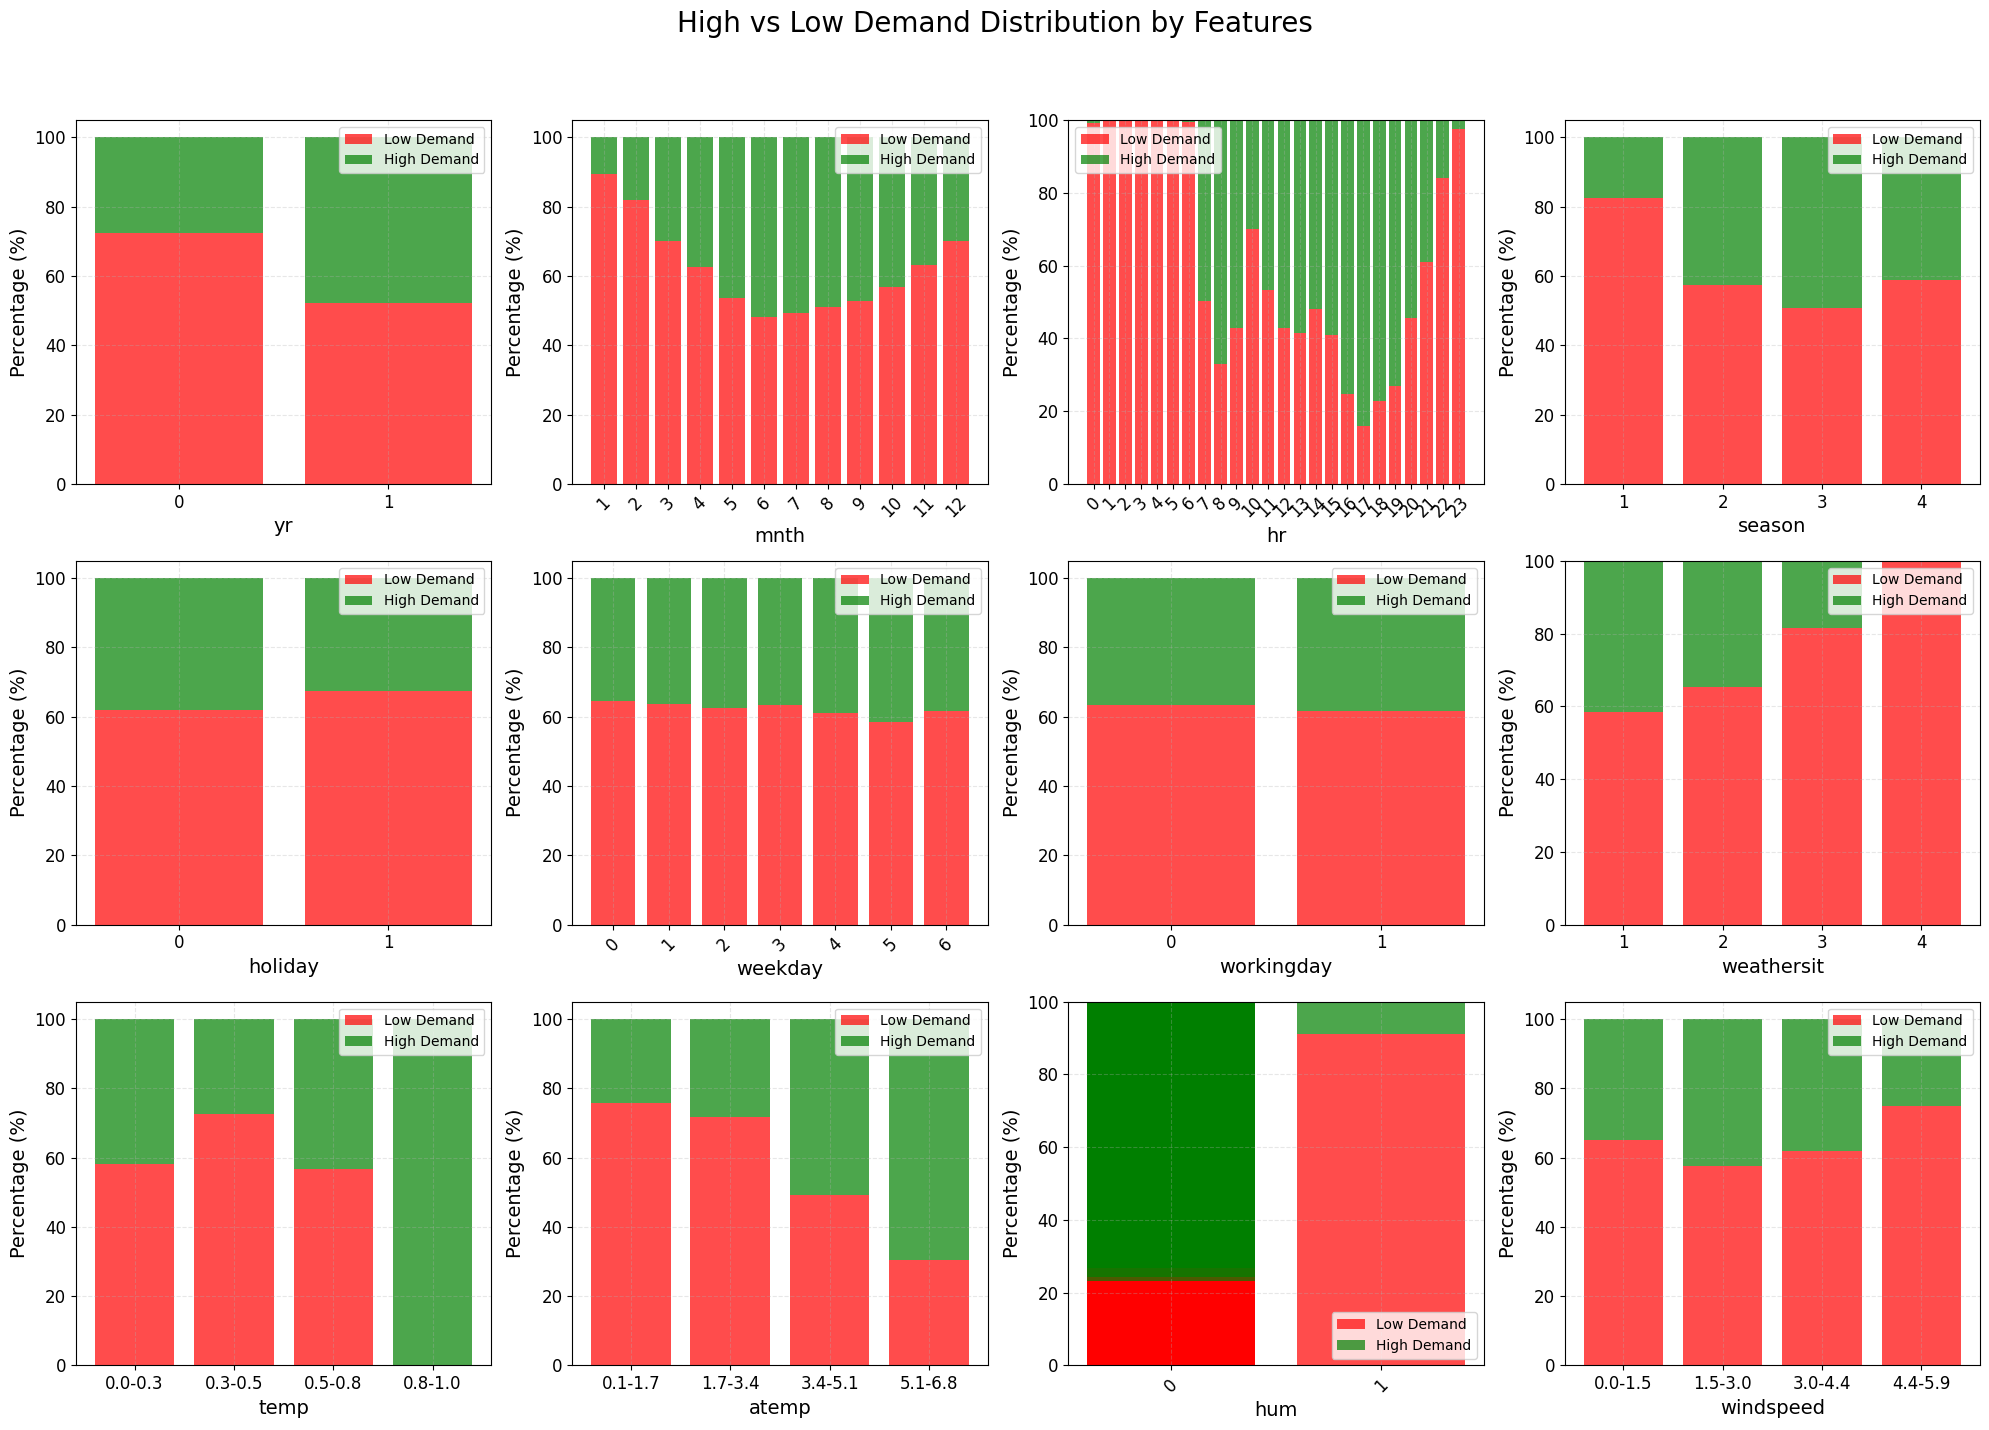

In [5]:
# Create subplots for each feature
fig, ax = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('High vs Low Demand Distribution by Features', fontsize=20)

# Flatten ax array for easier iteration
ax = ax.ravel()

for i in range(len(ax)):
    feature_vals = X_train[:, i]

    # For numeric features (temp, atemp, humidity, windspeed), create bins
    if X_features[i] in ['temp', 'atemp', 'humidity', 'windspeed']:
        # Create 4 bins
        bins = np.linspace(feature_vals.min(), feature_vals.max(), 5)
        labels = [f'{bins[j]:.1f}-{bins[j+1]:.1f}' for j in range(len(bins)-1)]
        feature_vals = np.digitize(feature_vals, bins[1:-1])
        unique_vals = np.arange(len(labels))
        x_labels = labels
    else:
        # For categorical features, use as-is
        unique_vals = np.unique(feature_vals)
        x_labels = [str(int(val)) for val in unique_vals]

    high_demand = []
    low_demand = []

    # Calculate counts for high and low demand
    for val in unique_vals:
        mask = feature_vals == val
        total = np.sum(mask)
        if total > 0:
            high_count = np.sum(y_train[mask] == 1)
            low_count = np.sum(y_train[mask] == 0)
            # Convert to percentages
            high_demand.append((high_count / total) * 100)
            low_demand.append((low_count / total) * 100)

    # Create stacked bar plot
    ax[i].bar(x_labels, low_demand, label='Low Demand', color='red', alpha=0.7)
    ax[i].bar(x_labels, high_demand, bottom=low_demand, label='High Demand', color='green', alpha=0.7)

    ax[i].set_xlabel(X_features[i], fontsize=14)
    ax[i].set_ylabel('Percentage (%)', fontsize=14)
    ax[i].tick_params(axis='x', rotation=45 if len(x_labels) > 4 else 0)
    ax[i].grid(True, linestyle='--', alpha=0.3)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## TASK 1: Data Analysis

Looking at the figures, choose what you think is the most and least informative feature to predict bike demand. Justify your answer.

Introduce your answer in the cell below.




I would identify the feels-like temp as the least informative. While it is important, a lot of overlap is shared between that feature and the normal tempature feature. Also when people look at their weather apps and such, the feels-like tempature is usually seen as an afterthought and not the main purpose of looking at the weather.

The most informative feature to predict the bike demand is without a doubt the hourly feature, as it allows us to quite clearly predict when throughout the day the demand would be highest.


### Answer (approx 200 words)




# 2. Model Defintion



The provided code snippet demonstrates how to build, train, and evaluate a **logistic regression model** using Keras, a popular deep learning library. The model is designed to predict high demand in a bike-sharing dataset.



## TASK 2A: HYPERPARAMETER TUNING

When training your logistic regression model using Keras, selecting the right hyperparameters is essential to ensure optimal performance and generalization to unseen data. In this task, you are required to determine suitable values for three key hyperparameters: the **learning rate**, the **number of epochs**, and the **validation split**. Each of these decisions plays a critical role in shaping the training process and the model's final accuracy.

For each hyperparameter, provide a clear rationale for your chosen values. To guide your reasoning, consider the following:

- **Learning Rate**:  
  How does your selected learning rate balance the trade-off between model convergence speed and training stability? What potential issues, such as slow convergence or overshooting, could arise with suboptimal values?

- **Number of Epochs**:  
  Why is your chosen number of epochs appropriate, given the complexity of your dataset and the risk of overfitting or underfitting? How do you plan to monitor performance during training to refine this choice?

- **Validation Split**:  
  How does your chosen validation split ensure a robust and reliable evaluation of your model’s performance during training? What considerations (e.g., dataset size or class balance) influenced this decision?

Provide your reasoning and selected values in the cell below. Be sure to connect your choices to the specifics of your dataset and model to demonstrate a thoughtful approach to hyperparameter tuning.

**If the training takes longer than 2 min consider stop the training and do not explore these configurations.**


In [ ]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

def build_model(hp):
    model = Sequential()
    model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Instantiate the tuner
tuner = kt.GridSearch(
    build_model,
    objective='val_accuracy',
    max_epochs=12,
    factor=3,
    directory='my_dir',
    project_name='logistic_regression_tuning'
)

# Load your data
# Ensure X_train and y_train are already defined

# Run the tuner
tuner.search(X_train, y_train, epochs=12, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=12, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

TypeError: SklearnTuner.__init__() missing 1 required positional argument: 'hypermodel'

### Answer (approx 200 words)

The core of logistic regression is the sigmoid function, which maps any real-valued number into a value between 0 and 1, making it suitable for estimating probabilities. 
I've introduced a learning rate of 0.001, with a validation split on 0.20 and a epoch amount of 12. The training set is used to perform the initial training of the model, initializing the weights of the neural network. The validation set is used after the neural network has been trained. It is used for tuning the network's hyperparameters, and comparing how changes to them affect the predictive accuracy of the model. Whereas the training set can be thought of as being used to build the neural network's gate weights, the validation set allows fine tuning of the parameters or architecture of the neural network model. It's useful as it allows repeatable comparison of these different parameters/architectures against the same data and networks weights, to observe how parameter/architecture changes affect the predictive power of the network. Although with a simpel models like this, and without the use of regularization and multiple layers, it plateaus pretty quickly suggesting its beginning to overfit to the data. The reason i've chosen these values are because the logistic regression model itself quite quickly can adapt to this data. 







## TASK 2B: Regularization

Regularization is a key technique in machine learning that prevents overfitting by adding a penalty to the loss function. Here you will explore how regularization affects the performance of a logistic regression model on the bike-sharing dataset.

1. Train a logistic regression models using Keras and L2 regularization.
* Use the Dense layer in Keras with the `kernel_regularizer` parameter to apply the regularization.
* Experiment with different values of the regularization strength and note their impact.

2. Evaluate the Models:

* Compare the performance of both models using accuracy and validation loss.

Epoch 1/32
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5081 - loss: 1.0350 - val_accuracy: 0.5505 - val_loss: 0.8075
Epoch 2/32
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5651 - loss: 0.7723 - val_accuracy: 0.5880 - val_loss: 0.6998
Epoch 3/32
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5975 - loss: 0.6881 - val_accuracy: 0.6285 - val_loss: 0.6434
Epoch 4/32
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6483 - loss: 0.6345 - val_accuracy: 0.6705 - val_loss: 0.6141
Epoch 5/32
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6850 - loss: 0.6005 - val_accuracy: 0.6955 - val_loss: 0.5990
Epoch 6/32
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6904 - loss: 0.5942 - val_accuracy: 0.6940 - val_loss: 0.5911
Epoch 7/32
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6957 - loss: 0.5867 - val_accuracy: 0.7100 - val_loss: 0.5861
Epoch 8/32
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7046 - loss: 0.5843 - val_accuracy: 0.

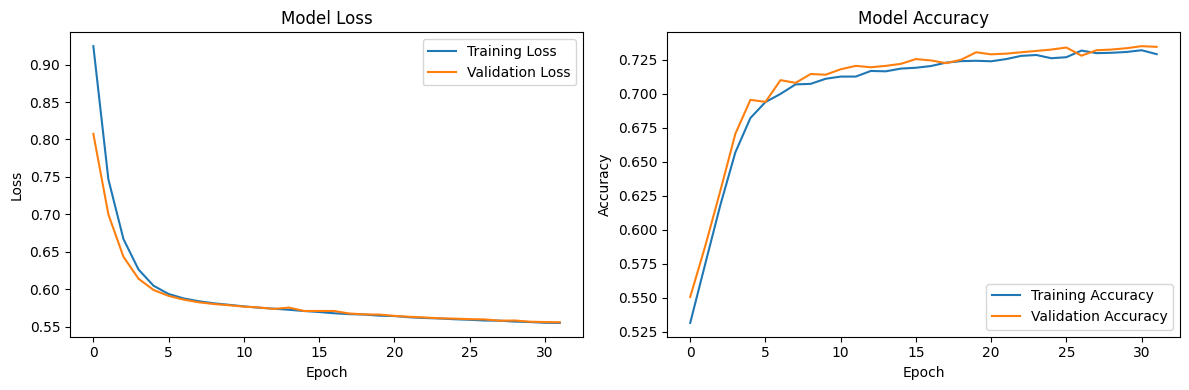

Final Training Loss: 0.5551
Final Training Accuracy: 0.7291
Final Validation Loss: 0.5559
Final Validation Accuracy: 0.7345


In [7]:
# Import necessary libraries from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import regularizers

# Define the model
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], kernel_regularizer=regularizers.L2(0.01), activation='sigmoid'))  # Logistic regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train, y_train,
                   epochs=32,
                   batch_size=32,
                   validation_split=0.2,
                   verbose=1,
                   shuffle=True)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

### Answer (150 + 200 words)
 1. Briefly explain in the purpose of regularization and how L2 regularization works. (150 words)

Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes. This penalty discourages the model from assigning too much importance to any single feature, which helps to prevent overfitting. Regularization thereby reduces model complexity, forcing it to focus on significant patterns and avoid noise. In logistic regression, this helps handle multicollinearity; in linear regression, it prevents overfitting in high-dimensional spaces.  The main aim of regularization is to help the model learn a simpler function to promote generalizations. L2 regularization adds the sum of the squared values of the model’s coefficients to the loss function. 
This encourages its coefficients to be small, which can prevent overfitting by spreading the influence of a single feature across multiple features.
 
 2. Discuss how the regularization terms affected the models in terms of overfitting and underfitting. (200 words)
When talking about the model above, i've increased the epoch amount as to give the model more time to apply regularizations and to better showcase it in above graph, and i've added a regularization amount of 0.01. 



## TASK 2C: CREATING A MULTI-LAYER PERCEPTRON

Now that you have gained experience training models, your next task is to create a **multilayer perceptron (MLP)** using Keras and train it as you did in previous exercises. Follow the steps below to guide your experimentation:

- **Create and Experiment with Different Architectures**:  
  - Vary the **number of layers**.  
  - Adjust the **number of neurons in each layer (width)** .  
  - Use **different activation functions**.  

-  **Train the MLP with L2 regularization**.
   - Use the Dense layer in Keras with the kernel_regularizer parameter to apply the regularization.
   - Experiment with different values of the regularization strength and note their impact.

- **Train and Evaluate**:  
  - Train each configuration and monitor the key metrics (e.g., accuracy, loss) to compare different configurations.  

- **Analyze and Discuss**:  
  - Discuss your findings and justify which one would be the best configuration for this dataset and problem.  


**If the training takes longer than 2 min consider stop the training and do not explore these configurations.**


Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6109 - loss: 7.1824 - val_accuracy: 0.6370 - val_loss: 6.0025
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6225 - loss: 6.1763 - val_accuracy: 0.6370 - val_loss: 5.8603
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6271 - loss: 6.0151 - val_accuracy: 0.6370 - val_loss: 5.8512
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6265 - loss: 6.0206 - val_accuracy: 0.6370 - val_loss: 5.8509
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6189 - loss: 6.1424 - val_accuracy: 0.6370 - val_loss: 5.8509
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6172 - loss: 6.1699 - val_accuracy: 0.6370 - val_loss: 5.8509
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6164 - loss: 6.1821 - val_accuracy: 0.6370 - val_loss: 5.8509
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6146 - loss: 6.2113 - val_accuracy: 0.

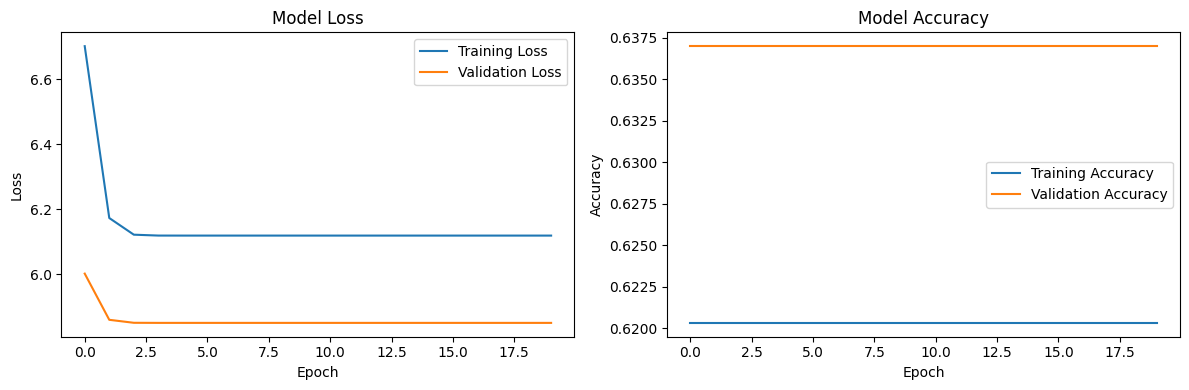

Final Training Loss: 6.1195
Final Training Accuracy: 0.6203
Final Validation Loss: 5.8509
Final Validation Accuracy: 0.6370


In [8]:
#Introduce the code for the MLP here
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Define the model
model = Sequential()
#input
model.add(Dense(12, input_dim=X_train.shape[1], activation='sigmoid', kernel_regularizer=regularizers.L2(0.001)))


model.add(Dense(16, activation='sigmoid', kernel_regularizer=regularizers.L2(0.1)))

#hidden
model.add(Dense(8, activation='softmax', kernel_regularizer=regularizers.L2(0.01)))

#outout
model.add(Dense(1, input_dim=X_train.shape[1]))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train, y_train,
                   epochs=20,
                   batch_size=30,
                   validation_split=0.1,
                   verbose=1)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
# Print final metrics
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

### Answer (approx 300 words)
**"Introduce your answer here"**

In logistic regression, the absence of layers simplifies the model, making them interpretable but limited in capturing non-linear relationships. To capture these i've tried including multiple layers as seen above.
While experimenting with the:
  - **Number of layers**.  
  - **Number of neurons in each layer (width)** .  
  - **Different activation functions**.  
I haven't really been able to find a configuration which seems to outperform the single layered logistic regression model seen above.
Even with the intoduction of the regularizer the results seems very varied, and i think i might've set it up incorrectly, but can't seem to figure out where.
Use the Dense layer in Keras with the kernel_regularizer parameter to apply the regularization.

With that said i havent found a version of this multilayered model which outperformed my earlier model. The one above fluctuates a lot, which would indicate too high learning rate, but reducing this in combination with the regularizer leads to the model getting stuck in local minima. I've tried multiple configurations and activation functions and havent gotten a combination which surpasses an accuracy of 73.

# Task 3. Model Evaluation

## Task 3a: What metric(s) are the most appropriate for your evaluation setup, and why? (100 words)

Theres a lot of metrics for evaluating of logistic regression models; Noteable ones we could use, and have used include confusion matrixies and accuracy. More importantly Precision and recall, and f1-scores could also be looked at, but throughout the tasks we havent really done that.

Confusion matrixies are a tabular representation of the model’s predictions versus the actual values. It consists of four components: true positive (TP), false positive (FP), false negative (FN), and true negative (TN), and would be a easy way of evaluating the model prediction from based on the dataset. It provides a detailed breakdown of classification performance, and could reveal areas of model bias or misclassification. 

Accuracy, is a metric which encompasses the overall correctness of the model’s predictions and is calculated as the ratio of correct predictions to the total number of predictions. However, accuracy may not be reliable when dealing with imbalanced datasets. Luckily our dataset i very balanced with every entry in it, including every feature.


## Task 3b: What changes in these metrics did you observe with different models and hyperparameter settings? (100 words)
Notable observations for accuracy:

Accuracy and Validation Accuracy :
Training Accuracy Increases, Validation Accuracy Plateaus: 
Indication: Overfitting. 
The model memorizes training data, including noise, but fails to generalize to unseen data. 

Both Training and Validation Accuracy Plateau at Low Values: 
Indication: Underfitting. 
The model lacks capacity or is poorly configured (e.g., insufficient layers or neurons). 
Add more layers or increase neuron count. For linear regression, revisit feature selection and scaling. 

Validation Accuracy Fluctuates:
Indication: High learning rate or insufficient data. 
A high learning rate causes oscillations, as the model overshoots optimal parameter values. Insufficient data increases sensitivity to noise. 
Reduce the learning rate to stabilize convergence. 

Loss and Validation Loss 
Validation Loss Increases as Training Loss Decreases: 
Indication: Overfitting. 
The model fits noise in the training data, deviating from general patterns useful for validation. 
Regularization techniques like L2 penalize large weights, and discouraging overfitting.

Both Losses Decrease Consistently: 
Indication: Effective learning. The model captures underlying data patterns; good training and validation performance. 

# TASK 4. Recurrent Neural Networks.

##4a: Describe how a Recurrent Neural Network could be implemented in the context of this exam's data set (100 words)

While traditional deep neural networks assume that inputs and outputs are independent of each other, the output of recurrent neural networks depend on the prior elements within the sequence. 


##4b: Standard Recurrent Neural Networks can struggle with longer input lengths. (1) Explain two of the main reasons why this phenomenon occurs, and (2) explain at least one architecture that solves this issue, and the intuition behind how this works. (200 words)

Recurrent neural networks share the same weight parameter within each layer of the network. That said, these weights are still adjusted in the through the processes of backpropagation and gradient 
descent to facilitate reinforcement learning. Recurrent neural networks leverage backpropagation through time BPTT algorithm to determine the gradients, which is slightly different from traditional backpropagation as it is specific to sequence data. The principles of BPTT are the same as traditional backpropagation, where the model trains itself by calculating errors from its output layer to its input layer. These calculations allow us to adjust and fit the parameters of the model appropriately. BPTT differs from the traditional approach in that BPTT sums errors at each time step whereas feedforward networks do not need to sum errors as they do not share parameters across each layer. Through this process, RNNs tend to run into two problems, known as exploding gradients and vanishing gradients. These issues are defined by the size of the gradient, which is the slope of the loss function along the error curve. When the gradient is too small, it continues to become smaller, updating the weight parameters until they become insignificant -> 0. When that occurs, the algorithm is no longer learning. Exploding gradients occur when the gradient is too large, creating an unstable model. In this case, the model weights will grow too large, and they will eventually be represented as NaN. One solution to these issues is to reduce the number of hidden layers within the neural network, eliminating some of the complexity in the RNN model. LSTMs are a special kind of Recurrent Neural Network RNN capable of learning 
long-term dependencies. They were developed to overcome the problem of short term memory in traditional RNNs.

### Answer 4a (100 words):



### Answer 4b (200 words):

# Task 5. Discussion of relevant take-aways. Take care to use correct terminology as presented in the course, and discuss subjects related to the course material.

## 5a: Takeaways from Dataset (100 words)

## 5b: Takeaways from Model (100 words)

## 5c: Takeaways from Evaluation (100 words)


### Answer 5a (100 words):

### Answer 5b (100 words):

### Answer 5c (100 words):

In [9]:
# Thank you for attending the course!